# Goal of this notebook: Examine whether there is a difference in insertion/deletion mutation propensity between MSS and MSI patients

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd

sns.set_context("poster")
%matplotlib inline

In [2]:
df_somatic_mutations = pd.read_csv("../../data/dummy_somatic_mutation_calls_filt.csv")
df_clinical = pd.read_csv("../../data/dummy_clinical.csv").assign(MSI = lambda x: pd.Categorical(x.MSI, categories=["MSS", "MSI"], ordered=True))

df_somatic_mutations.head()

,patient,tmp_id,period,ref,allele_a_healthy,allele_a_tumor,allele_b_healthy,allele_b_tumor,allele_a_diff,allele_b_diff,patient_len_diff
0,1,chr1_10008054,1,14,14,14,14,14,0,0,0
1,1,chr1_10014276,2,4,4,4,4,4,0,0,0
2,1,chr1_1004515,2,4,4,4,4,4,0,0,0
3,1,chr1_10054784,1,19,19,19,19,19,0,0,0
4,1,chr1_10059809,1,9,9,9,9,9,0,0,0


In [4]:
df_allele_lengths_long = (
    df_somatic_mutations
        .rename(columns={'allele_a_diff': 'a', 'allele_b_diff': 'b'})
        .merge(
            df_clinical.loc[:, ["patient", "MSI"]], 
            on="patient", 
            how="left")
        .melt(
            id_vars=['patient', 'MSI', 'tmp_id', 'ref', 'period'],
            value_vars=['a', 'b'], 
            var_name='allele', 
            value_name='allele_diff')
        .drop('allele', axis=1)
)

df_allele_lengths_long.head()

,patient,MSI,tmp_id,ref,period,allele_diff
0,1,MSS,chr1_10008054,14,1,0
1,1,MSS,chr1_10014276,4,2,0
2,1,MSS,chr1_1004515,4,2,0
3,1,MSS,chr1_10054784,19,1,0
4,1,MSS,chr1_10059809,9,1,0


## Plot changes in allele length caused by STR mutations

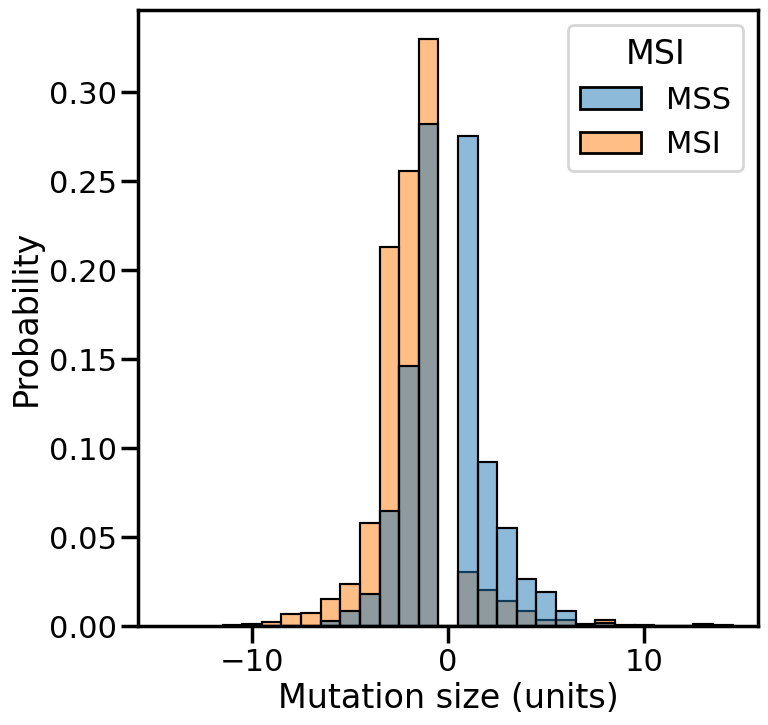

In [5]:
fig, ax = plt.subplots(figsize=(8, 8))

ax = sns.histplot(
    data=df_allele_lengths_long.query("allele_diff != 0 and allele_diff < 15 and allele_diff > -15"),
    x='allele_diff',
    hue='MSI',
    discrete=True,
    stat='probability',
    common_norm=False,
    ax=ax
)

edge = max([abs(i) for i in ax.get_xlim()])

ax.set(
    xlabel="Mutation size (units)",
    xlim=(-edge, edge)
)

plt.show()

Skipped period 2, bin (30, 40]
Skipped period 3, bin (30, 40]
Skipped period 4, bin (15, 30]
Skipped period 4, bin (30, 40]
Skipped period 5, bin (15, 30]
Skipped period 5, bin (30, 40]
Skipped period 6, bin (15, 30]
Skipped period 6, bin (30, 40]


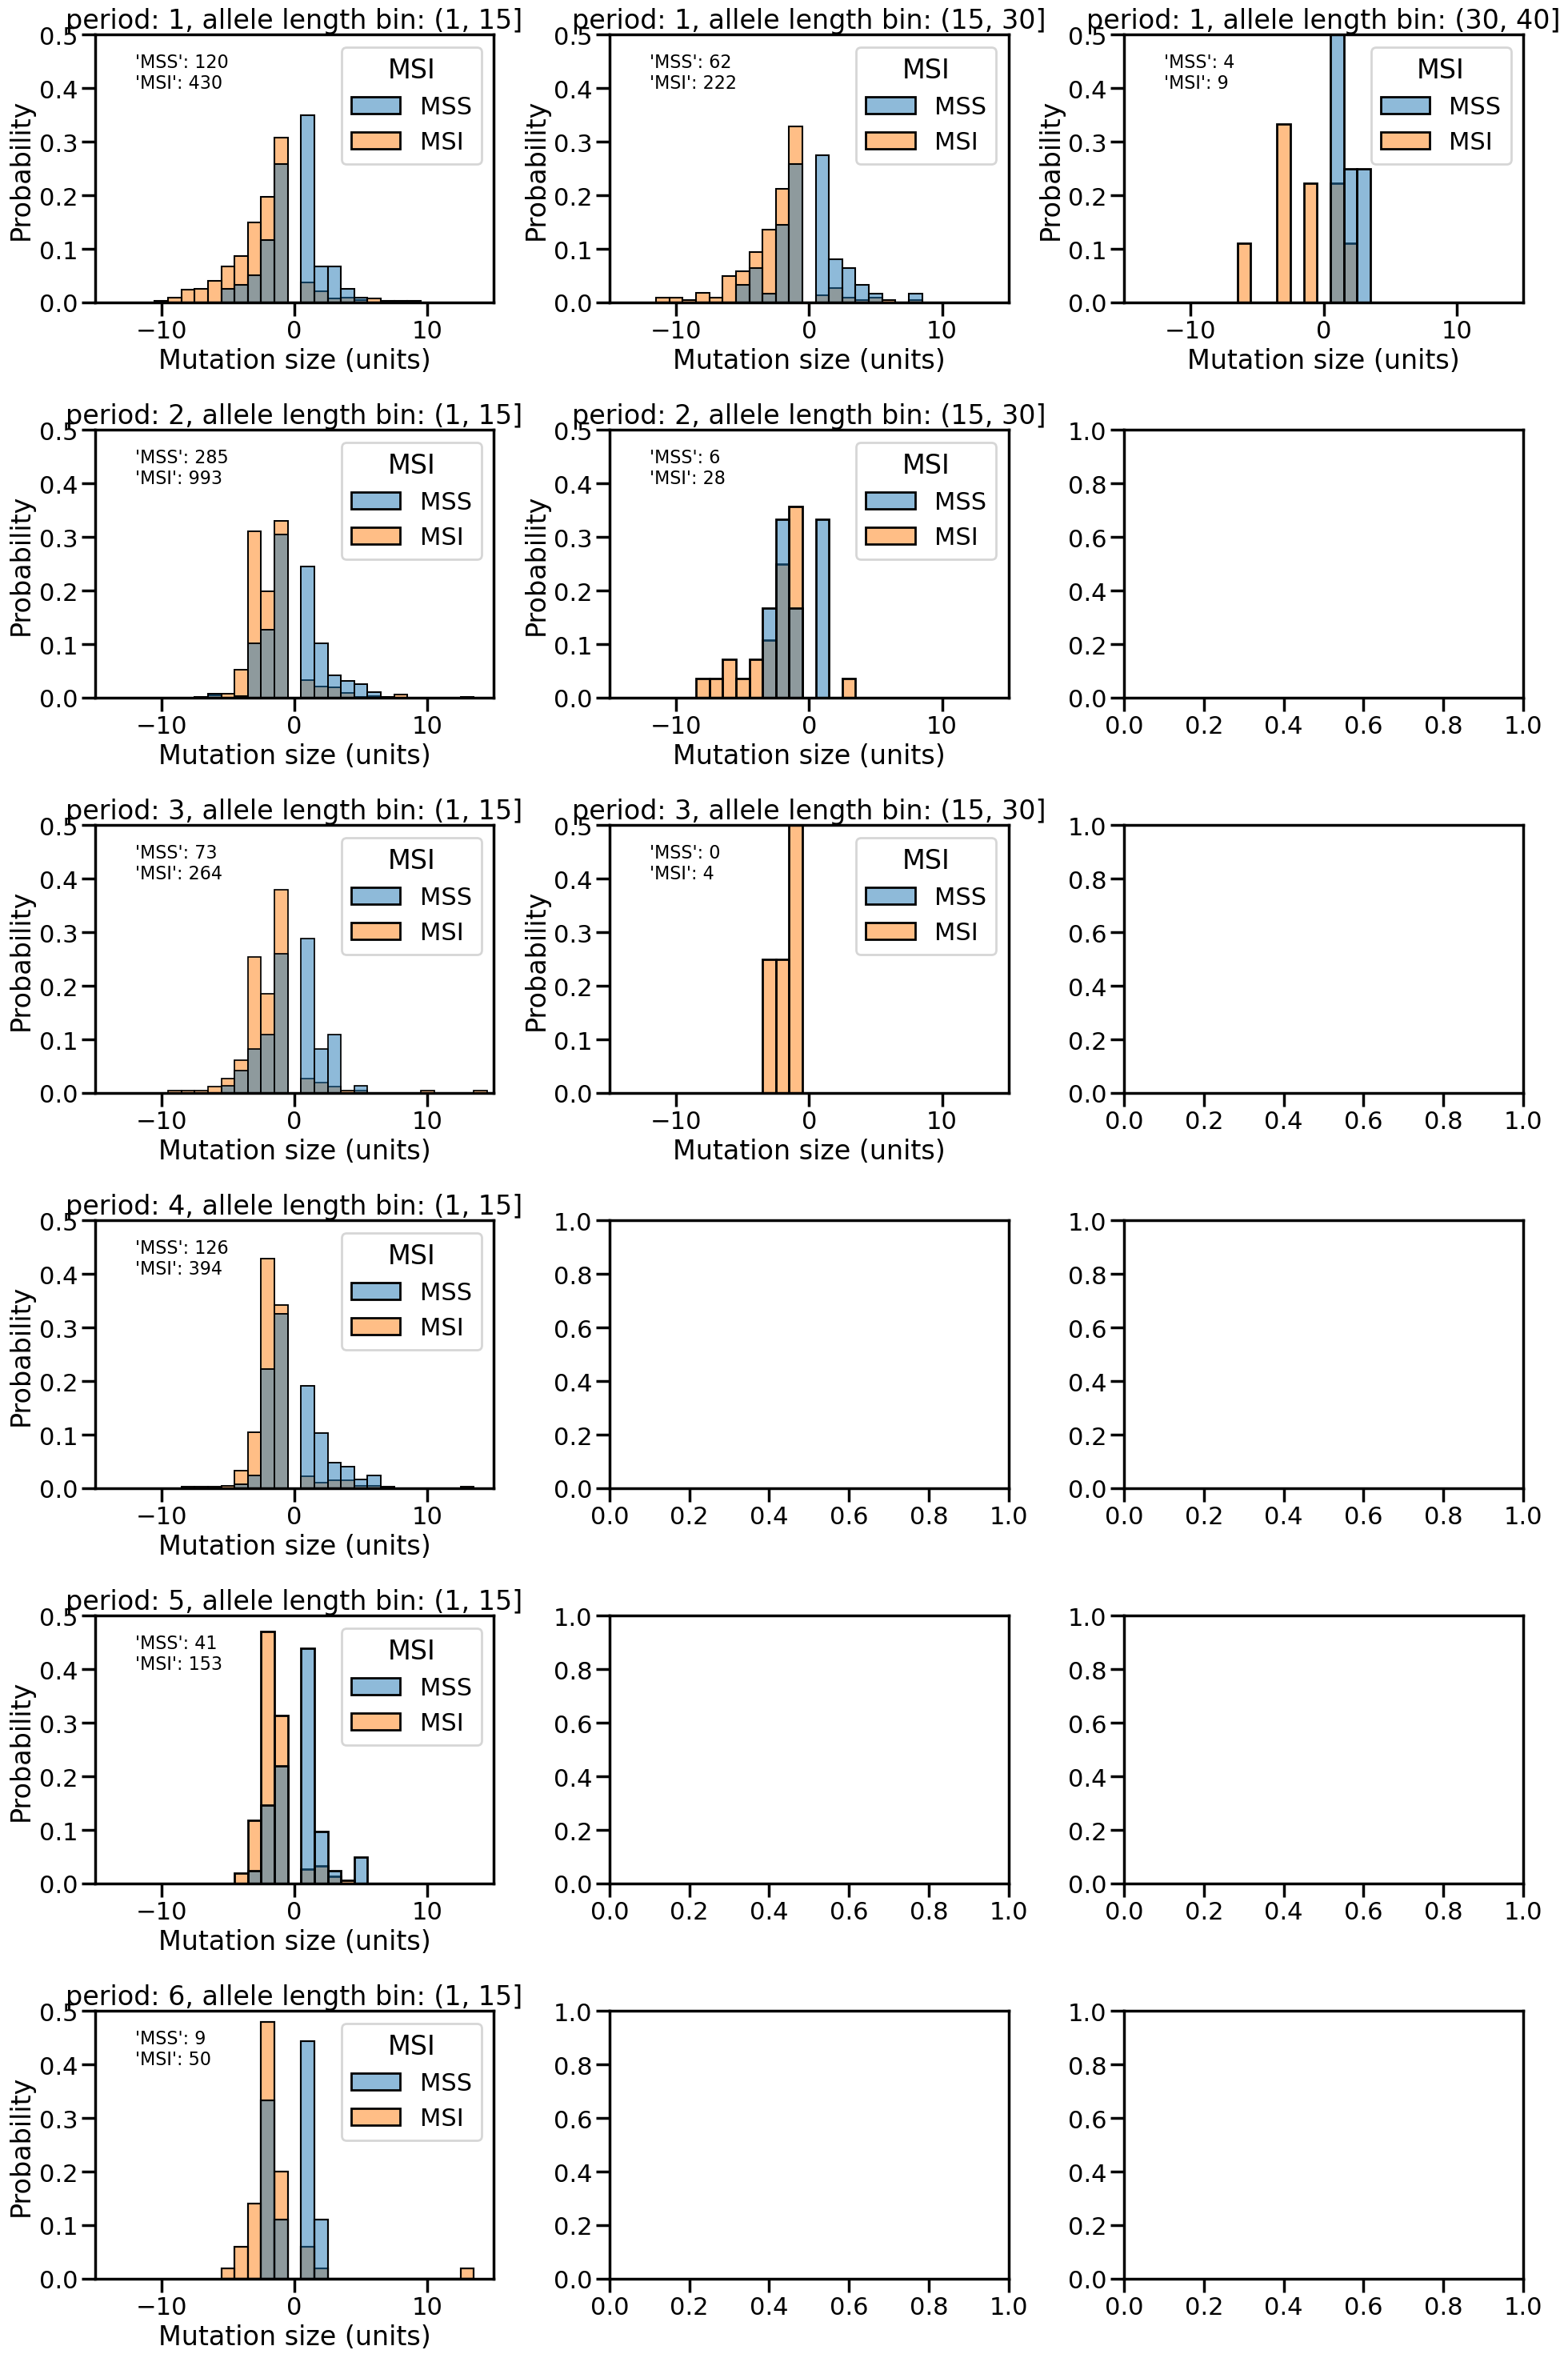

In [98]:
fig, axes = plt.subplots(
    nrows=6, 
    ncols=3, 
    figsize=(20, 30),
    sharex=False,
    sharey=False
)  

bins = [1, 15, 30, df_allele_lengths_long.ref.max()]
df_histplots = (
    df_allele_lengths_long
        .query("allele_diff != 0 and allele_diff <= 15 and allele_diff >= -15")
        .assign(ref_bin = lambda x: pd.cut(x.ref, bins=bins))
)

# every bin has a column, every period has a row
for ax, period, bin in zip(
        axes.ravel(), 
        np.repeat([1, 2, 3, 4, 5, 6], 3), 
        np.tile(df_histplots.ref_bin.unique().sort_values(), 6)):
    df_cur_panel = df_histplots.loc[(df_histplots.ref_bin == bin) & (df_histplots.period == period)]
    if len(df_cur_panel) <= 2:
        print(f"Skipped period {period}, bin {bin}")
        continue
        
    sns.histplot(
        data=df_cur_panel,
        x='allele_diff',
        hue='MSI',
        discrete=True,
        stat='probability',
        common_norm=False,
        ax = ax,
    )        
    
    ax.set(
        title=f"period: {period}, allele length bin: {bin}", 
        xlabel="Mutation size (units)",
        xlim = (-15, 15),
        ylim = (0, 0.5)
    )
    
    text = str(dict(df_cur_panel.groupby("MSI").size())).replace(", ", "\n").replace("{", "").replace("}", "")
    ax.text(0.1, 0.8, s=text, transform=ax.transAxes, fontsize=16)

plt.tight_layout()

In [9]:
df_abs_mutation_size =  (df_allele_lengths_long
                            .query("allele_diff != 0")
                            .reset_index(drop=True)
                            .assign(abs_allele_diff = lambda x: abs(x.allele_diff)))

df_abs_mutation_size

,patient,MSI,tmp_id,ref,period,allele_diff,abs_allele_diff
0,1,MSS,chr1_10372810,3,4,1,1
1,1,MSS,chr1_10736285,4,2,1,1
2,1,MSS,chr1_11059289,4,2,-1,1
3,1,MSS,chr1_1204502,5,4,3,3
4,1,MSS,chr1_1269461,16,1,1,1
...,...,...,...,...,...,...,...
3269,50,MSI,chr1_8865208,3,4,-2,2
3270,50,MSI,chr1_9070838,8,2,-7,7
3271,50,MSI,chr1_9725046,4,2,8,8
3272,50,MSI,chr1_9930713,5,4,-1,1


In [13]:
df_abs_mutation_size[["MSI", "abs_allele_diff"]].groupby("MSI").agg("mean")

,abs_allele_diff
MSI,
MSS,1.785124
MSI,2.319074


In [14]:
from scipy import stats

stats.ttest_ind(
    a=df_abs_mutation_size.query("MSI == 'MSI'").abs_allele_diff,
    b=df_abs_mutation_size.query("MSI == 'MSS'").abs_allele_diff
)

TtestResult(statistic=8.585795803311397, pvalue=1.3731368435011343e-17, df=3272.0)

In [15]:
stats.mannwhitneyu(
    x=df_abs_mutation_size.query("MSI == 'MSI'").abs_allele_diff,
    y=df_abs_mutation_size.query("MSI == 'MSS'").abs_allele_diff
)

MannwhitneyuResult(statistic=1135484.5, pvalue=7.340026950897797e-23)

In [22]:
(
    df_abs_mutation_size[["MSI", "abs_allele_diff"]]
        .groupby(["MSI"], as_index=True)
        .value_counts(normalize=True)
        .unstack()
)




abs_allele_diff,1,2,3,4,5,6,7,8,9,10,11,13,14,17
MSI,,,,,,,,,,,,,,
MSS,0.557851,0.238292,0.119835,0.044077,0.027548,0.011019,0.000000,0.001377,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
MSI,0.359890,0.275510,0.227237,0.066327,0.027080,0.018838,0.008242,0.009812,0.002747,0.00157,0.000785,0.001177,0.000392,0.000392


In [48]:
df_totals = (df_abs_mutation_size
             .groupby(["MSI", "period"], as_index=False)
             .size()
             .rename(columns = {"size": "total_n_calls"}))

df_subtotals = (df_abs_mutation_size
     .groupby(["MSI", "period", "abs_allele_diff"], as_index=False)
     .size()
     .rename(columns = {"size": "n_calls"})
     .merge(df_totals, on=["MSI", "period"])
     .assign(frac = lambda x: x.n_calls / x.total_n_calls)
     .pivot(index=["period", "abs_allele_diff"], columns="MSI", values="frac"))

df_subtotals.query("abs_allele_diff <= 5").unstack()

MSI                   MSS                                               MSI  \
abs_allele_diff         1         2         3         4         5         1   
period                                                                        
1                0.580645  0.198925  0.107527  0.069892  0.037634  0.344932   
2                0.549828  0.230241  0.144330  0.034364  0.024055  0.363369   
3                0.547945  0.191781  0.191781  0.041096  0.027397  0.405204   
4                0.515873  0.325397  0.071429  0.047619  0.015873  0.365482   
5                0.658537  0.243902  0.048780  0.000000  0.048780  0.339869   
6                0.555556  0.444444  0.000000  0.000000  0.000000  0.260000   

MSI                                                      
abs_allele_diff         2         3         4         5  
period                                                   
1                0.223903  0.154312  0.095310  0.069592  
2                0.219393  0.325171  0.061704  0.009794  
3                0.204461  0.263941  0.063197  0.029740  
4                0.439086  0.119289  0.048223  0.010152  
5                0.503268  0.130719  0.026144  0.000000  
6                0.500000  0.140000  0.060000  0.020000

## Testing for a mutation direction bias

First: contingency table of expansions vs. contractions observed in MSS and MSI patients. Then, tests to determine whether MSI patients have significantly more contractions than MSS patients.

In [49]:
df_contingency = (df_allele_lengths_long.query("allele_diff != 0")
             .assign(contraction = lambda x: x.allele_diff < 0)
             .groupby(["MSI", "contraction"], as_index=False).size()
             .rename(columns = {"size": "total_n_calls"})
             .pivot(index=["MSI"], columns="contraction", values="total_n_calls"))
df_contingency

contraction,False,True
MSI,,
MSS,347,379
MSI,222,2326


In [50]:
print(stats.fisher_exact(df_contingency))
print(stats.chi2_contingency(df_contingency))

SignificanceResult(statistic=9.592835579642967, pvalue=4.156156545280171e-113)
Chi2ContingencyResult(statistic=598.34484642213, pvalue=3.835384664700422e-132, dof=1, expected_freq=array([[ 126.17409896,  599.82590104],
       [ 442.82590104, 2105.17409896]]))


In [55]:
print(df_contingency.iloc[0, 1] / df_contingency.iloc[0, :].sum())
print(df_contingency.iloc[1, 1] / df_contingency.iloc[1, :].sum())

0.522038567493113
0.9128728414442701


In [56]:
(df_allele_lengths_long.query("allele_diff != 0")
             .assign(contraction = lambda x: x.allele_diff < 0)
             .groupby(["MSI", "period", "contraction"], as_index=False).size()
             .rename(columns = {"size": "total_n_calls"})
             .pivot(index=["period", "MSI"], columns="contraction", values="total_n_calls"))

contraction  False  True 
period MSI               
1      MSS      96     90
       MSI      59    602
2      MSS     132    159
       MSI      95    926
3      MSS      36     37
       MSI      20    249
4      MSS      53     73
       MSI      31    363
5      MSS      25     16
       MSI      12    141
6      MSS       5      4
       MSI       5     45

## Testing for a difference in absolute step size of mutations
Is there a difference in mutation size (i.e., the number of units inserted/deleted per STR mutation) between MSS and MSI patients?

In [99]:
df_allele_size =  (df_allele_lengths_long
                            .query("allele_diff != 0")
                            .assign(abs_allele_diff = lambda x: abs(x.allele_diff)))

df_allele_size

,patient,MSI,tmp_id,ref,period,allele_diff,abs_allele_diff
65,1,MSS,chr1_10372810,3,4,1,1
120,1,MSS,chr1_10736285,4,2,1,1
151,1,MSS,chr1_11059289,4,2,-1,1
260,1,MSS,chr1_1204502,5,4,3,3
347,1,MSS,chr1_1269461,16,1,1,1
...,...,...,...,...,...,...,...
99831,50,MSI,chr1_8865208,3,4,-2,2
99848,50,MSI,chr1_9070838,8,2,-7,7
99901,50,MSI,chr1_9725046,4,2,8,8
99937,50,MSI,chr1_9930713,5,4,-1,1


In [100]:
df_allele_size[["MSI", "abs_allele_diff"]].groupby("MSI").agg("mean")

,abs_allele_diff
MSI,
MSS,1.785124
MSI,2.319074


In [102]:
from scipy import stats

stats.ttest_ind(
    a=df_allele_size.query("MSI == 'MSI'").abs_allele_diff,
    b=df_allele_size.query("MSI == 'MSS'").abs_allele_diff
)

TtestResult(statistic=8.585795803311397, pvalue=1.3731368435011343e-17, df=3272.0)

In [104]:
stats.mannwhitneyu(
    x=df_allele_size.query("MSI == 'MSI'").abs_allele_diff,
    y=df_allele_size.query("MSI == 'MSS'").abs_allele_diff
)

MannwhitneyuResult(statistic=1135484.5, pvalue=7.340026950897797e-23)

In [106]:
df_totals = (df_allele_size
             .groupby(["MSI", "period"], as_index=False).size()
             .rename(columns = {"size": "total_n_calls"}))

df_subtotals = (df_allele_size
     .groupby(["MSI", "period", "abs_allele_diff"], as_index=False)
     .size().rename(columns = {"size": "n_calls"})
     .merge(df_totals, on=["MSI", "period"])
     .assign(frac = lambda x: x.n_calls / x.total_n_calls)
     .pivot(index=["period", "abs_allele_diff"], columns="MSI", values="frac"))
df_subtotals.query("abs_allele_diff < 5").unstack()

MSI                   MSS                                     MSI            \
abs_allele_diff         1         2         3         4         1         2   
period                                                                        
1                0.580645  0.198925  0.107527  0.069892  0.344932  0.223903   
2                0.549828  0.230241  0.144330  0.034364  0.363369  0.219393   
3                0.547945  0.191781  0.191781  0.041096  0.405204  0.204461   
4                0.515873  0.325397  0.071429  0.047619  0.365482  0.439086   
5                0.658537  0.243902  0.048780  0.000000  0.339869  0.503268   
6                0.555556  0.444444  0.000000  0.000000  0.260000  0.500000   

MSI                                  
abs_allele_diff         3         4  
period                               
1                0.154312  0.095310  
2                0.325171  0.061704  
3                0.263941  0.063197  
4                0.119289  0.048223  
5                0.130719  0.026144  
6                0.140000  0.060000